# Building a Report Picker eval

Based on the [examples in openai/evals](https://github.com/openai/evals/tree/26a5191230e91953f4f2fdd74a82051fda2aba23/examples)

## Imports

In [120]:
%load_ext autoreload
%autoreload 2

import datetime
import os
import pandas as pd
import yaml
import json

from pathlib import Path

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load prompt

Construct the system prompt, similar to `../lib/openai.ts`: `createSystemPrompt`

In [121]:
with open("../lib/prompt_template.json") as f:
    prompt_template_data = json.load(f)
    prompt_template_prompt = prompt_template_data['prompt'] # Adjust this based on the actual structure

with open("../lib/available_reports/square.json") as f:
    available_reports = json.load(f)

sample_date = "2023-08-21"

# Construct the system prompt, BUT with the temp added lined until we solve using
# function calling in the API call
system_prompt = f"""
{prompt_template_prompt}

Today's date: {sample_date}

Reply with ONLY the key of a report below.

Available reports: 
{available_reports}
"""

system_prompt

'\nYou\'re an expert at finding the best report(s) to answer a user\'s question about their business. If the question isn\'t answerable by these reports, return "NA" as the "error".\n\nToday\'s date: 2023-08-21\n\nReply with ONLY the key of a report below.\n\nAvailable reports: \n[{\'key\': \'SalesSummary\', \'description\': \'Sales Summary: A general overview of sales from a given time period. The report includes itemization metrics like gross sales, refunds, net sales, discounts, tips, and taxes. It also includes payment metrics like total collected (revenue by tender type) and fees.\', \'filters\': [\'startDate\', \'endDate\']}, {\'key\': \'SalesTrends\', \'description\': \'Sales Trends: Compares your daily, weekly, and yearly gross sales.\', \'filters\': [\'startDate\', \'endDate\']}, {\'key\': \'PaymentMethods\', \'description\': \'Payment Methods: A summary of the total collected and any associated fees from credit, debit and gift cards, and any other tender types. The reports in

## Create `samples.jsonl` in local eval registry

In [122]:
eval_key = "report_picker"
registry_path = os.path.join(os.getcwd(), ".local_registry")
os.makedirs(os.path.join(registry_path, "evals"), exist_ok=True)
os.makedirs(os.path.join(registry_path, "data", eval_key), exist_ok=True)

def create_chat_prompt(user_question):
    return [
        {"role": "system", "content": system_prompt}, 
        {"role": "user", "content": user_question}
    ]

# Read the YAML file
yaml_file_path = os.path.join("report_questions.yaml")
with open(yaml_file_path, 'r') as f:
    yaml_data = yaml.load(f, Loader=yaml.FullLoader)

# Transform the dictionary
data = []
for key, questions in yaml_data.items():
    for question in questions:
        input_prompt = create_chat_prompt(question)
        data.append({"input": input_prompt, "ideal": key})

# Convert to a Pandas DataFrame
df = pd.DataFrame(data)

# Save to a JSON file
json_output_path = os.path.join(registry_path, "data", eval_key, "samples.jsonl")
df.to_json(json_output_path, orient="records", lines=True)

# Display the DataFrame
display(df.head())

,input,ideal
0,"[{'role': 'system', 'content': ' You're an expert at finding the best report(s) to answer a user's question about their business. If the question isn't answerable by these reports, return ""NA"" as ...",SalesSummary
1,"[{'role': 'system', 'content': ' You're an expert at finding the best report(s) to answer a user's question about their business. If the question isn't answerable by these reports, return ""NA"" as ...",SalesSummary
2,"[{'role': 'system', 'content': ' You're an expert at finding the best report(s) to answer a user's question about their business. If the question isn't answerable by these reports, return ""NA"" as ...",SalesSummary
3,"[{'role': 'system', 'content': ' You're an expert at finding the best report(s) to answer a user's question about their business. If the question isn't answerable by these reports, return ""NA"" as ...",SalesTrends
4,"[{'role': 'system', 'content': ' You're an expert at finding the best report(s) to answer a user's question about their business. If the question isn't answerable by these reports, return ""NA"" as ...",SalesTrends


## Create the eval `.yaml` in local eval registry

In [123]:
samples_path = os.path.join(registry_path, "data", eval_key, "samples.jsonl")

eval_yaml = f"""
{eval_key}:
  id: {eval_key}.test.v0
  metrics: [accuracy]

{eval_key}.test.v0:
  class: evals.elsuite.basic.match:Match
  args:
    samples_jsonl: {samples_path}
""".strip()

with open(os.path.join(registry_path, "evals", f"{eval_key}.yaml"), "w") as f:
    f.write(eval_yaml)

## Run eval

Using oaieval CLI tool from OpenAI

In [124]:
def run_evaluation(model, eval_key, filename_timestamp, registry_path):
    results_file_name = f"{eval_key}-{model}-{filename_timestamp}.jsonl"

    # Get the absolute path to the registry
    abs_registry_path = os.path.abspath(registry_path)

    # Create the results directory
    results_dir = os.path.join(os.getcwd(), ".results")
    os.makedirs(results_dir, exist_ok=True)
    abs_record_path = os.path.join(results_dir, results_file_name)

    # Check if the file exists
    file_path = Path(abs_record_path)
    if file_path.is_file():
        print(f"The file {results_file_name} already exists.")
        return

    # Uncomment args as needed
    extra_args = [
        # "--debug",
        # "--dry-run",
        # "--max_samples 5",
        f"--registry_path {abs_registry_path}",
        f"--record_path {abs_record_path}"
    ]

    # Run the eval with paths passed in
    get_ipython().system(f"oaieval {model} {eval_key} {' '.join(extra_args)}")


In [125]:
# Make changes in this cell and re-run it. Then re-run the next cell to store a new eval in the `.results` directory.

# Compare different models
model = "gpt-3.5-turbo"
# model = "gpt-4"

filename_timestamp = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

In [126]:
# Re-running just this cell without re-running the previous cell should be a no-op
run_evaluation(model, eval_key, filename_timestamp, registry_path)

[2023-08-22 11:06:10,191] [registry.py:249] Loading registry from /Users/briansigafoos/Development/briansigafoos/report-picker-gpt/evals/venv/lib/python3.11/site-packages/evals/registry/evals
[2023-08-22 11:06:10,245] [registry.py:249] Loading registry from /Users/briansigafoos/.evals/evals
[2023-08-22 11:06:10,245] [registry.py:249] Loading registry from /Users/briansigafoos/Development/briansigafoos/report-picker-gpt/evals/.local_registry/evals
[2023-08-22 11:06:10,246] [oaieval.py:110] Run started: 230822150610OOQLVIOR
[2023-08-22 11:06:10,246] [data.py:75] Fetching /Users/briansigafoos/Development/briansigafoos/report-picker-gpt/evals/.local_registry/data/report_picker/samples.jsonl
[2023-08-22 11:06:10,250] [eval.py:34] Evaluating 60 samples
[2023-08-22 11:06:10,257] [eval.py:153] Running in threaded mode with 10 threads!
100%|███████████████████████████████████████████| 60/60 [00:01<00:00, 32.08it/s]
[2023-08-22 11:06:12,130] [record.py:320] Final report: {'accuracy': 0.716666666

## View results and mistakes

<Axes: title={'center': 'Correctness of generated answers'}, xlabel='Correct', ylabel='Count'>

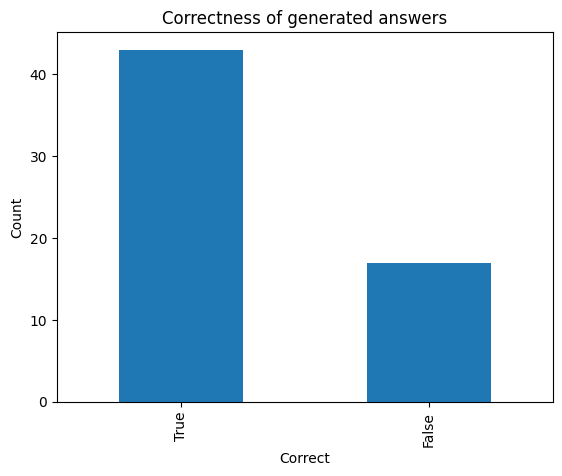

In [127]:
# Load the results into a DataFrame
with open(abs_record_path, "r") as f:
    df = pd.read_json(f, lines=True)

matches_df = df[events_df.type == "match"].reset_index(drop=True)
matches_df = df.join(pd.json_normalize(matches_df.data))
matches_df.correct.value_counts().plot.bar(title="Correctness of generated answers", xlabel="Correct", ylabel="Count")

In [129]:
# Customize Pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 200)
pd.set_option('display.width', 1000)

# Function to check if correct is False
def is_incorrect(row):
    return isinstance(row, dict) and row.get('correct') == False

# Filter incorrect matches and create a copy
mistakes_df = df[df['data'].apply(is_incorrect)].copy()

# Function to find the question for a specific sample_id
def find_user_question(sample_id):
    row = df[df['sample_id'] == sample_id].iloc[0]
    user_content = next((item['content'] for item in row['data']['prompt'] if item['role'] == 'user'), None)
    return user_content

# Apply the function to the mistakes DataFrame to find the question
mistakes_df['question'] = mistakes_df['sample_id'].apply(find_user_question)

# Extract expected and actual values
mistakes_df['expected'] = mistakes_df['data'].apply(lambda x: x['expected'])
mistakes_df['actual'] = mistakes_df['data'].apply(lambda x: x['sampled'])

# Display the expected, sampled columns along with user content
result_df = mistakes_df[['question', 'expected', 'actual']]
print(result_df)

                                                                                                                      question        expected           actual
3                                           What were the activity logs for discounts and comps/voids during a specific event?     ActivityLog               NA
7                                                        How were the cash drawers managed during the year-end clearance sale?     CashDrawers               NA
11   How can I track sensitive actions taken by the team, like processed refunds and changes to inventory, for the past month?     ActivityLog     Activity Log
15                                     How can I track everything related to Square gift card activity for the holiday season?       GiftCards       Gift Cards
27                                                         How many voided items were there during the last special promotion?           Voids               NA
35                                      